
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Lab: Diving into the Transformer - Utilizing embeddings from transformers

In this lab, we will delve into the workings of the Transformer's encoder. We will build the components needed to create our encoder-based model and investigate the embeddings it produces. You will then be asked questions related to these embeddings, including comparisons, distance measurements, and the utilization of masked language modeling (MLM).

### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives
1. Develop an encoder from scratch
2. Investigating word embeddings (from our untrained models, and BERT)
4. Gain practice in Masked Language Modeling (MLM)

## Classroom Setup

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

First, can you explain what a sequential deep neural network is in PyTorch?
In PyTorch, a sequential deep neural network is a way to define a neural network model by stacking layers sequentially. 
This allows you to easily create a feedforward neural network by specifying the layers in the order they should be executed.

Now, can you tell me what you understand about functional deep neural networks in PyTorch?

Functional deep neural networks in PyTorch involve defining the network architecture using the functional API provided by PyTorch. 
This approach allows for more flexibility in defining complex neural network architectures compared to the sequential method.

Can you think of a scenario where you might prefer to use a functional deep neural network instead of a sequential one in PyTorch?
One scenario where you might prefer to use a functional deep neural network in PyTorch is when you need to implement complex architectures that involve branching or skipping connections. The functional API allows you to define custom operations and control the flow of data more explicitly, making it suitable for such scenarios.

# Section 1 - Building our own Encoder Transformer

### Define the Feed Forward Network

We begin by defining the FeedForward class, which represents a simple feed-forward neural network with two linear layers separated by a ReLU activation function, and a dropout layer for regularization.

This code defines a FeedForward neural network module in PyTorch. Here's a breakdown of what each part of the code does:

class FeedForward(nn.Module):: This line defines a new class named FeedForward that inherits from nn.Module, which is the base class for all neural network modules in PyTorch.

def __init__(self, d_model, hidden_dim, dropout = 0.1):: This is the initialization function for the FeedForward class. It takes three parameters: d_model (the input size), hidden_dim (the size of the hidden layer), and dropout (the dropout probability, with a default value of 0.1). Inside this function:

self.fc1 = nn.Linear(d_model, hidden_dim): This line creates a linear transformation layer (nn.Linear) that maps inputs of size d_model to outputs of size hidden_dim.
self.fc2 = nn.Linear(hidden_dim, d_model): This line creates another linear transformation layer that maps inputs of size hidden_dim back to the original input size d_model.
self.dropout = nn.Dropout(dropout): This line creates a dropout layer with the specified dropout probability.
def forward(self, x):: This function defines the forward pass of the neural network. It takes an input tensor x and passes it through the network layers. Inside this function:

out = self.fc1(x): This line applies the first linear transformation to the input x.
out = F.relu(out): This line applies the ReLU activation function to the output of the first linear layer.
out = self.dropout(out): This line applies dropout to the output of the ReLU activation.
out = self.fc2(out): This line applies the second linear transformation to the output of the dropout layer.
return out: Finally, the output of the second linear layer is returned as the output of the forward pass.
This FeedForward module can be used as a component in a larger neural network architecture, typically within a Transformer model or similar deep learning architecture. It applies two linear transformations with a ReLU activation function and dropout in between, allowing for non-linear transformations and regularization during training.

In [0]:
class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, dropout = 0.1):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


### Define the Transformer Encoder Block

The TransformerEncoderBlock class represents a single block of the transformer encoder, which consists of a multi-head self-attention layer and a feed-forward neural network, with layer normalization and residual connections applied to the outputs of each layer.

This code defines a Transformer Encoder Block module in PyTorch. Here's an explanation of each part of the code:

class TransformerEncoderBlock(nn.Module):: This line defines a class named TransformerEncoderBlock that inherits from nn.Module.

def __init__(self, d_model, num_heads, conv_hidden_dim, dropout=0.1):: This is the initialization function for the TransformerEncoderBlock class. It takes four parameters: d_model (dimension of model), num_heads (number of attention heads), conv_hidden_dim (dimension of the hidden layer in the feedforward network), and dropout (dropout probability, defaulting to 0.1). Inside this function:

self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout): This line creates a multi-head attention layer with the specified parameters.
self.norm1 = nn.LayerNorm(d_model): This line creates a layer normalization layer for the first normalization step.
self.norm2 = nn.LayerNorm(d_model): This line creates a layer normalization layer for the second normalization step.
self.feed_forward = FeedForward(d_model, conv_hidden_dim, dropout): This line creates a feedforward network module with the specified parameters.
self.dropout = nn.Dropout(dropout): This line creates a dropout layer with the specified dropout probability.
def forward(self, x, mask=None):: This function defines the forward pass of the Transformer Encoder Block. It takes an input tensor x and an optional mask. Inside this function:

attn_output, _ = self.attention(x, x, x, attn_mask=mask): This line applies multi-head attention to the input x with optional attention mask mask.
x = x + self.dropout(attn_output): This line adds the output of the attention layer to the input after applying dropout.
x = self.norm1(x): This line applies layer normalization to the output of the attention layer.
ff_output = self.feed_forward(x): This line passes the normalized output through the feedforward network.
x = x + self.dropout(ff_output): This line adds the output of the feedforward network to the previous output after applying dropout.
x = self.norm2(x): This line applies layer normalization to the final output before returning it.
This Transformer Encoder Block module encapsulates the components of a single block in a Transformer encoder, including multi-head attention, layer normalization, feedforward network, dropout, and residual connections. It can be stacked to form a complete Transformer encoder architecture for tasks like natural language processing and sequence modeling.


In [0]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, conv_hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-Head Attention
        attn_output, _ = self.attention(x, x, x, attn_mask=mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # Feed Forward Network
        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)

        return x


### Define the Transformer Encoder

The TransformerEncoder class represents the complete transformer encoder, which consists of a word embedding layer, a positional encoding layer, and a series of transformer encoder blocks.

In [0]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, conv_hidden_dim, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(1000, d_model)  # Assuming a maximum sequence length of 1000
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(d_model, num_heads, conv_hidden_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, mask=None):
        seq_length = x.shape[1]
        positions = torch.arange(0, seq_length).expand(x.shape[0], seq_length).to(x.device)
        out = self.word_embedding(x) + self.position_embedding(positions)

        for layer in self.layers:
            out = layer(out, mask)

        return out


### Instantiate the Model and Perform a Forward Pass

We now instantiate the model with a specific set of hyperparameters, generate some random input data, and perform a forward pass through the model.

In [0]:
# Assume the following hyperparameters
vocab_size = 5000  # size of the vocabulary
d_model = 512  # dimension of the word embedding
num_heads = 8  # number of attention heads
conv_hidden_dim = 2048  # dimension of the hidden layer in the feed-forward network
num_layers = 6  # number of Transformer Encoder blocks
dropout = 0.1  # dropout rate

# Instantiate the model
model = TransformerEncoder(vocab_size, d_model, num_heads, conv_hidden_dim, num_layers, dropout)

# Generate some example input
input_tensor = torch.randint(0, vocab_size, (1, 20))  # batch size of 1 and sequence length of 20

# Forward pass through the model
output = model(input_tensor, mask=None)



print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

The model has 21,986,304 trainable parameters


### Investigate Word Embeddings

We now generate some random input data and perform a forward pass through the model to obtain the embeddings for each word in the input.

In [0]:
# Generate some example input
input_tensor = torch.randint(0, vocab_size, (1, 5))  # batch size of 1 and sequence length of 5

# Forward pass through the model
embeddings = model(input_tensor, mask=None)

# The `embeddings` tensor now contains the contextualized embeddings for each word in the input sequence
print(embeddings)


tensor([[[-0.6224, -0.2451,  1.4899,  ..., -0.0423, -0.9514,  0.0682],
         [-1.5299, -2.1988,  0.1265,  ...,  1.1045, -1.0590,  1.9056],
         [ 0.7666,  1.5753, -0.9337,  ...,  0.3570,  1.3319,  1.0954],
         [ 0.2954,  1.0343, -0.6400,  ...,  1.4719,  0.6980, -1.5223],
         [ 0.5441,  0.9375, -1.1850,  ...,  0.8551,  0.0944, -0.4503]]],
       grad_fn=<NativeLayerNormBackward0>)


### Define Vocabulary and Word-to-ID Mapping

To interpret the input and output of our model, we define a vocabulary and a mapping from words to their corresponding IDs.

In [0]:
# Let's assume the following is our vocabulary
vocabulary = [
    "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", 
    "the", "a", "an", 
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    "runs", "jumps", "sleeps", "eats", "drinks",
    "fast", "slow", "big", "small", "red", "green", "blue", "yellow",
    "is", "was", "will", "can", "has", "have", "had", "do", "does",
    "I", "you", "he", "she", "it", "we", "they",
    "my", "your", "his", "her", "its", "our", "their"
]

# Create a word2id dictionary
word2id = {word: idx for idx, word in enumerate(vocabulary)}

# Print the dictionary
print(word2id)


{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, 'the': 5, 'a': 6, 'an': 7, 'cat': 8, 'dog': 9, 'fish': 10, 'bird': 11, 'lion': 12, 'tiger': 13, 'elephant': 14, 'monkey': 15, 'runs': 16, 'jumps': 17, 'sleeps': 18, 'eats': 19, 'drinks': 20, 'fast': 21, 'slow': 22, 'big': 23, 'small': 24, 'red': 25, 'green': 26, 'blue': 27, 'yellow': 28, 'is': 29, 'was': 30, 'will': 31, 'can': 32, 'has': 33, 'have': 34, 'had': 35, 'do': 36, 'does': 37, 'I': 38, 'you': 39, 'he': 40, 'she': 41, 'it': 42, 'we': 43, 'they': 44, 'my': 45, 'your': 46, 'his': 47, 'her': 48, 'its': 49, 'our': 50, 'their': 51}


### Measure Sentence Similarity

We define a function to measure the cosine similarity between two sentences, which is done by averaging the embeddings of the words in each sentence and then calculating the cosine similarity between these average embeddings.

In [0]:
# Define a simple function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    vec1 = vec1.squeeze()  # remove dimensions of size 1
    vec2 = vec2.squeeze()  # remove dimensions of size 1
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

# Define a function to convert a sentence into embeddings
def sentence_to_embeddings(sentence, model, word2id):
    # Convert sentence to token ids
    input_tensor = torch.tensor([word2id.get(word, word2id["[UNK]"]) for word in sentence.split()], dtype=torch.long).unsqueeze(0)
    embeddings = model(input_tensor, mask=None)
    return embeddings

# Define a function to compute the similarity between two sentences
def sentence_similarity(sentence1, sentence2, model, word2id):
    embeddings1 = sentence_to_embeddings(sentence1, model, word2id)
    embeddings2 = sentence_to_embeddings(sentence2, model, word2id)

    # Compute the average embeddings of each sentence
    avg_embedding1 = torch.mean(embeddings1, dim=1)
    avg_embedding2 = torch.mean(embeddings2, dim=1)

    # Compute and return the cosine similarity
    return cosine_similarity(avg_embedding1, avg_embedding2)

# Now we can compute the similarity between two sentences
sentence1 = "the cat has a blue fish"
sentence2 = "my sister's dog sleeps"
# Compute the similarity
similarity = sentence_similarity(sentence1, sentence2, model, word2id)

# Extract the value from the tensor and convert it to a Python float
similarity_score = similarity.item()

# Print the result with a descriptive sentence
print(f"The cosine similarity between the sentences '{sentence1}' and '{sentence2}' is {similarity_score:.2f}.")

The cosine similarity between the sentences 'the cat has a blue fish' and 'my sister's dog sleeps' is 0.57.


### Visualize Word Embeddings

We define a function to visualize the embeddings of a set of words in 2D space, which is done by using PCA to reduce the dimensionality of the embeddings to 2 and then plotting them.

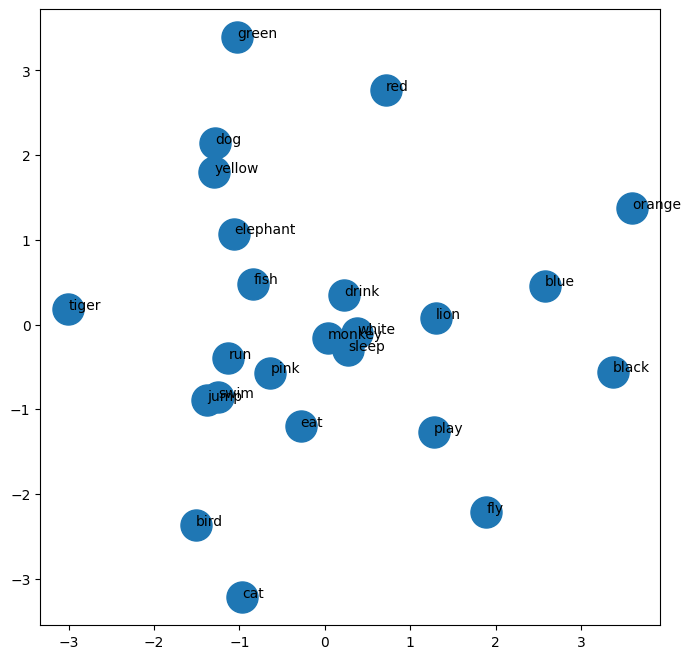

In [0]:
# Import necessary libraries
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define a list of words to plot
words = [
    # Animals
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    # Colors
    "red", "green", "blue", "yellow", "black", "white", "pink", "orange",
    # Verbs
    "run", "jump", "swim", "fly", "eat", "drink", "sleep", "play"
]
# Create artificial embeddings for demonstration purposes
embeddings = np.array([np.random.rand(512) for _ in words])  # 512 is the dimension of the embeddings

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()



### Compare with Pre-Trained BERT Embeddings

We load a pre-trained BERT model, generate embeddings for a set of words, and visualize them in the same way as before.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


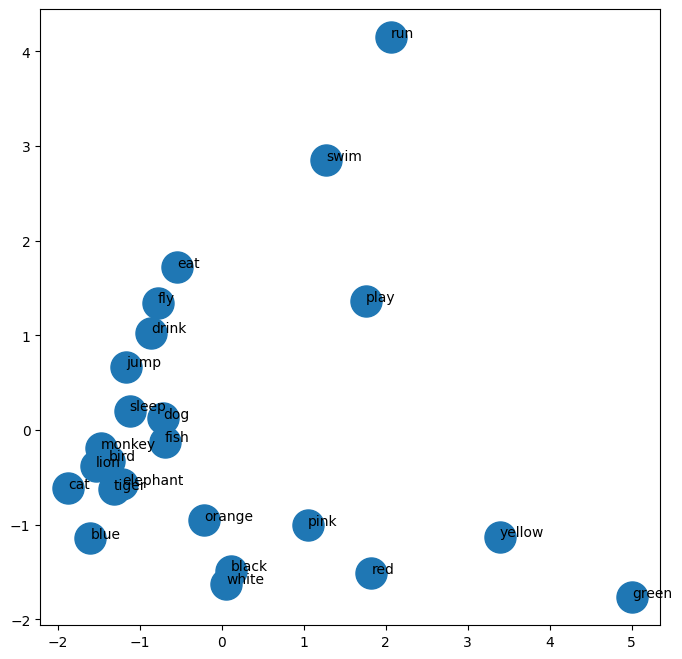

In [0]:
# Import necessary libraries
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model_bert = BertModel.from_pretrained(model_name, cache_dir=DA.paths.datasets+"/models")
tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir=DA.paths.datasets+"/models")

# Define a list of words to plot
words = [
    # Animals
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    # Colors
    "red", "green", "blue", "yellow", "black", "white", "pink", "orange",
    # Verbs
    "run", "jump", "swim", "fly", "eat", "drink", "sleep", "play"
]
# Get the embeddings of the words
embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model_bert(**inputs)
    embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

# Section 1 - Questions

Having built our transformer encoder and inspected the embeddings it produces, we can now explore some questions related to these embeddings.

**Question 1:** 
How does changing different hyperparameters (e.g., the dimension of the word embeddings, the number of attention heads, the dimension of the hidden layer in the feed-forward network, the number of encoder blocks, and the dropout rate) affect the overall size of the model?

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
# TODO
# Use different parameters to see the effects on the overall model size. 
# Create a Transformer Encoder with different hyperparameters
vocab_size = 1000  # size of the vocabulary
d_model = 512  # dimension of the word embedding
num_heads = 2  # number of attention heads
conv_hidden_dim = 2048  # dimension of the hidden layer in the feed-forward network
num_layers = 2  # number of Transformer Encoder blocks
dropout = 0.1  # dropout rate

# Instantiate the model
new_model = TransformerEncoder(vocab_size, d_model, num_heads, conv_hidden_dim, num_layers, dropout)

# Generate some example input
input_tensor = torch.randint(0, vocab_size, (1, 20))  # batch size of 1 and sequence length of 20

# Forward pass through the model
output = model(input_tensor, mask=None)

print(f"The model has {count_parameters(new_model):,} trainable parameters, compared to the 21,986,304 of the original model")

The model has 7,328,768 trainable parameters, compared to the 21,986,304 of the original model


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_1(new_model)

PASSED: All tests passed for lesson1, question1
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 2:** 
Visualize the embeddings of a different set of words. Try choosing a set of words that are related in some way, such as words related to a particular topic or words that are all of a certain type (e.g., all verbs or all nouns).

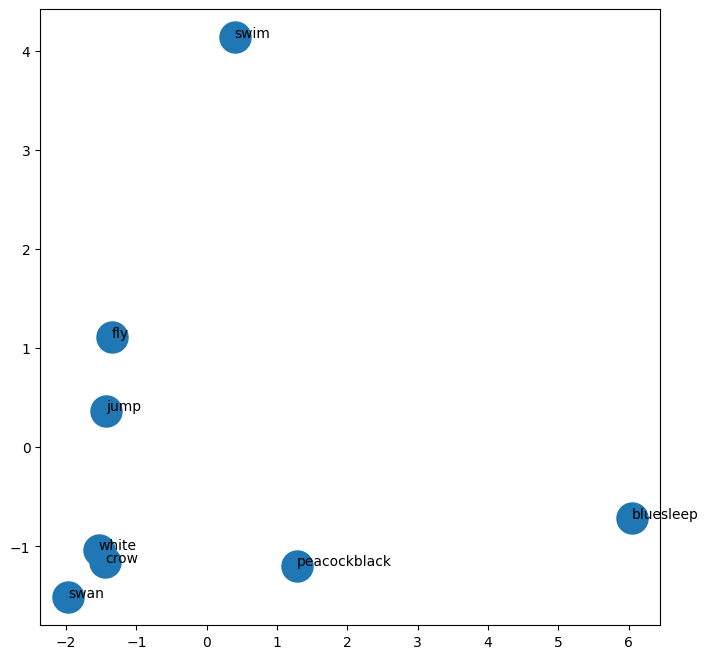

In [0]:
# TODO
words = [
    # birds
    "swan", "crow", "peacock"
    # Colors
    "black", "white", "blue"
    # Verbs
    "sleep", "jump", "swim", "fly"
]

# Get the embeddings of the words
embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model_bert(**inputs)
    embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_2(words)

PASSED: All tests passed for lesson1, question2
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 3:** 
Compute the cosine similarity between the embeddings of a sentence and its scrambled version. For example, compare the sentence "the cat chased the dog" with "dog the chased cat the". What do you observe?

In [0]:
# TODO
# Define a sentence and its scrambled version
sentence_q3 = "the cat chased the dog"
scrambled_sentence_q3 = "dog the chased cat the"

# Compute embeddings and cosine similarity
original_embedding = sentence_to_embeddings(sentence_q3, model, word2id)
scrambled_embedding = sentence_to_embeddings(scrambled_sentence_q3, model, word2id)

# Compute the average embeddings of each sentence
avg_embedding_original = torch.mean(original_embedding, dim=1)
avg_embedding_scrambled = torch.mean(scrambled_embedding, dim=1)

similarity = cosine_similarity(avg_embedding_original, avg_embedding_scrambled)
print("Cosine similarity between original and scrambled sentence embeddings:", similarity.item())



Cosine similarity between original and scrambled sentence embeddings: 0.8358564972877502


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_3(sentence_q3, scrambled_sentence_q3)

PASSED: All tests passed for lesson1, question3
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 4:** 
Compute the cosine similarity between the embeddings of a word used in two different contexts. For example, try the word `bank`, "he needs to bank the money" vs. "he is going to the bank of the river". What do you observe?

In [0]:
# TODO
# Define two sentences where a word has different meanings
sentence_q4a = "he needs to bank the money"
sentence_q4b = "he is going to the bank of the river"
# Compute embeddings and cosine similarity
embedding1 = sentence_to_embeddings(sentence_q4a, model, word2id)
embedding2 = sentence_to_embeddings(sentence_q4b, model, word2id)

# Compute the average embeddings of each sentence
avg_embedding1 = torch.mean(embedding1, dim=1)
avg_embedding2 = torch.mean(embedding2, dim=1)

similarity = cosine_similarity(avg_embedding1, avg_embedding2)
print(f"Cosine similarity between embeddings of the word 'bank' in two different contexts: {similarity.item()}")

Cosine similarity between embeddings of the word 'bank' in two different contexts: 0.850875973701477


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_4(sentence_q4a, sentence_q4b)

PASSED: All tests passed for lesson1, question4
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


# Section 2 - Masked Language Modeling (MLM) with BERT

One of the training tasks for BERT is Masked Language Modeling (MLM). In MLM, some percentage of the input tokens are masked at random, and the objective is to predict the original vocabulary id of the masked word based only on its context. Unlike traditional language modeling, MLM is not a sequential task because BERT uses the entire context (left and right of the mask) to predict the masked word. This allows BERT to pre-train a deep bidirectional representation in a straightforward way, which is difficult in standard language modeling.

BERT (Bidirectional Encoder Representations from Transformers) can be applied in various ways in Natural Language Processing tasks, Decision Making processes, and Transfer Learning scenarios:

Natural Language Processing (NLP) Tasks:

BERT can be used for tasks such as sentiment analysis, named entity recognition, question answering, text classification, and language translation. Its ability to capture contextual information and semantic relationships makes it effective in understanding and generating natural language text.
Decision Making Processes:

In decision-making processes, BERT can assist in analyzing large volumes of text data to extract insights, identify patterns, and make informed decisions. By understanding the context and meaning of text, BERT can support decision-making in areas such as customer feedback analysis, risk assessment, and sentiment analysis.
Transfer Learning Scenarios:


BERT's pre-trained language representations can be fine-tuned on specific tasks with smaller datasets, making it suitable for transfer learning. By leveraging the knowledge learned during pre-training, BERT can be adapted to new tasks such as text classification, entity recognition, or sentiment analysis with improved performance and efficiency.
How do you think the application of BERT in these areas can benefit organizations and researchers in improving language understanding, decision-making processes, and transfer learning tasks?


### Masked Language Modeling with BERT

We load a pre-trained BERT model that has been fine-tuned for the masked language modeling (MLM) task. We then define a function to predict the word that should fill a `[MASK]` token in a sentence.

Masked Language Modeling (MLM) is a training task used in BERT (Bidirectional Encoder Representations from Transformers) where some of the input tokens are masked out, and the model is trained to predict the masked tokens based on the context provided by the surrounding tokens. This helps BERT learn bidirectional representations of the text by forcing the model to understand and predict missing words in a sentence.

How do you think the concept of MLM helps BERT in capturing contextual information and improving its understanding of language during training?
The concept of Masked Language Modeling (MLM) in BERT helps the model capture contextual information by training it to predict missing words in a sentence based on the surrounding context. This process encourages BERT to understand the relationships between words in a sentence and learn the nuances of language usage. By predicting masked tokens, BERT is forced to consider the context of the entire sentence, leading to a deeper understanding of language semantics and syntax.


Can you think of other ways in which training BERT with MLM can enhance the model's ability to comprehend and generate language?
Training BERT with Masked Language Modeling (MLM) can enhance the model's ability to comprehend and generate language in several ways:

Contextual Understanding: MLM encourages BERT to consider the context of a word within a sentence, leading to a better understanding of how words relate to each other in different contexts.

Semantic Relationships: By predicting masked tokens, BERT learns to capture semantic relationships between words, which helps in tasks like semantic similarity and word analogy.

Syntax and Grammar: Training with MLM helps BERT understand the syntactic structure of sentences and improves its ability to generate grammatically correct text.

Transfer Learning: MLM pre-training allows BERT to learn general language representations that can be fine-tuned for specific tasks, making it more adaptable and effective in various natural language processing tasks.

Reducing Data Requirements: Since MLM uses unsupervised learning, it can help BERT learn from large amounts of unlabeled text data, reducing the need for extensive labeled training data for downstream tasks.

How do you think these aspects of training with MLM contribute to BERT's effectiveness in understanding and generating language?

Training BERT with Masked Language Modeling (MLM) contributes to its effectiveness in understanding and generating language by enhancing its ability to:

Capture Contextual Information: By predicting masked tokens, BERT learns to consider the context of words in a sentence, leading to a better understanding of language nuances and improving its comprehension of text.

Learn Semantic Relationships: MLM helps BERT capture semantic relationships between words, enabling it to understand the meaning of words in different contexts and perform tasks like semantic similarity and word analogy effectively.

Understand Syntax and Grammar: Training with MLM helps BERT grasp the syntactic structure of sentences, allowing it to generate grammatically correct text and comprehend complex sentence structures.

Facilitate Transfer Learning: Pre-training with MLM enables BERT to learn general language representations that can be fine-tuned for specific tasks, making it versatile and effective in various natural language processing applications.

Utilize Unlabeled Data: MLM allows BERT to learn from large amounts of unlabeled text data, reducing the dependency on labeled data for training, which can be particularly beneficial in scenarios where labeled data is scarce.

How do you think these contributions of MLM training make BERT a powerful tool for natural language processing tasks?
The contributions of Masked Language Modeling (MLM) training make BERT a powerful tool for natural language processing tasks by enhancing its ability to:

Understand Context: BERT's training with MLM enables it to understand the context of words in a sentence, allowing it to capture subtle nuances and meanings in language.

Capture Semantic Relationships: By learning semantic relationships between words, BERT can effectively interpret and generate text with a deeper understanding of word meanings and associations.

Handle Syntax and Grammar: BERT's training with MLM helps it grasp the syntactic structure of sentences, leading to improved performance in tasks requiring grammatical accuracy and complex sentence comprehension.

Adaptability: The pre-training with MLM makes BERT adaptable for various natural language processing tasks through fine-tuning, enhancing its performance and efficiency in different applications.

Data Efficiency: MLM training allows BERT to leverage unlabeled data effectively, reducing the need for large amounts of labeled data and making it a cost-effective solution for NLP tasks.

In [0]:
# Import the necessary libraries
from transformers import BertTokenizer, BertForMaskedLM

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir=DA.paths.datasets+"/models")
mlm_model = BertForMaskedLM.from_pretrained("bert-base-uncased", cache_dir=DA.paths.datasets+"/models")

# Define a function to predict masked words
def predict_masked_words(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_token_ids = outputs.logits.argmax(dim=-1)
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_token_ids[0])
    return " ".join(predicted_tokens)

# Define a sentence with a masked word
sentence = "I love to play [MASK] ball."
print(predict_masked_words(sentence, mlm_model, tokenizer))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


. i love to play the ball . i


### Predict Different Masked Words

We define different sentences with masked words and use our model to predict what these masked words should be.

In [0]:
# Define different sentences with masked words
sentences = [
    "The weather today is [MASK].",
    "I like to eat [MASK] for breakfast.",
    "She is a [MASK] woman.",
    "He drives a [MASK] car.",
    "They are going to the [MASK]."
]

# Use the model to predict the masked words
for sentence in sentences:
    print(predict_masked_words(sentence, mlm_model, tokenizer))

. the weather today is warm . .
. i like to eat it for breakfast . i
. she is a beautiful woman . .
. he drives a sports car . .
. they are going to the hospital . .


### Experiment with Different Sentences

We define even more sentences with masked words and use our model to predict what these masked words should be.

In [0]:
# Define more sentences with masked words
sentences = [
    "My favorite color is [MASK].",
    "The cat sat on the [MASK].",
    "I am reading a [MASK] book.",
    "She has a [MASK] of apples.",
    "He plays the [MASK] in a band."
]

# Use the model to predict the masked words
for sentence in sentences:
    print(predict_masked_words(sentence, mlm_model, tokenizer))

. my favorite color is pink . .
. the cat sat on the floor . .
. i am reading a comic book . .
. she has a basket of apples . .
. he plays the guitar in a band . .


# Section 2 - Questions

Having explored the use of BERT for masked language modeling, we can now explore some questions related to this task.

**Question 5:** 
What happens when you mask more than one word in a sentence? Can the model accurately predict both masked words?

In [0]:
# TODO
# Define a sentence with two masked words
sentence_q5 = ["I love to play [MASK] ball with friends. [MASK] know when to go out"]
print(predict_masked_words(sentence_q5, mlm_model, tokenizer))

. i love to play beach ball with friends . i know when to go . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_5(sentence_q5)

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
File <command-300840241083388>:3
      1 # Test your answer. DO NOT MODIFY THIS CELL.
----> 3 dbTestQuestion1_5(sentence_q5)

File <command-300840241083412>:41, in dbTestQuestion1_5(sentence_q5)
     38 lesson, question = "lesson1", "question5"
     39 userhome_for_testing = getUsernameFromEnv(lesson)
---> 41 assert sentence_q5.count("[MASK]") >= 2, "Test NOT passed: `[MASK]` should appear at least twice in your sentence."
     43 questionPassed(userhome_for_testing, lesson, question)

AssertionError: Test NOT passed: `[MASK]` should appear at least twice in your sentence.

**Question 6:** 
Use the model to predict the masked word in a sentence in a language other than English. Does the model accurately predict the masked word? Think about why/why not.

In [0]:
# TODO
# Define a sentence in French with a masked word
sentence_q6 = "Je t’aime et je veux sortir [MASK] toi"
# Je t’aime et je veux sortir avec toi
print(predict_masked_words(sentence_q6, mlm_model, tokenizer))

. je t ' aim ##e et je ve ##ux sort ##ir a to . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_6(sentence_q6)

PASSED: All tests passed for lesson1, question6
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 7:** 
Mask a word that has different meanings in different contexts. Does the model accurately predict the correct word based on the context?

In [0]:
# TODO
# Define two sentences where a word has different meanings
sentence_q7a = "Choose [MASK] date, for our next date"
sentence_q7b = "My mom is Kenyan, so I [MASK] part Kenyan. "
print(predict_masked_words(sentence_q7a, mlm_model, tokenizer))
print(predict_masked_words(sentence_q7b, mlm_model, tokenizer))

. choose a date , for our next . .
. my mom is kenyan , so i am part kenyan . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_7(sentence_q7a, sentence_q7b)

PASSED: All tests passed for lesson1, question7
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 8:** 
Mask a word in a sentence that makes sense only in a specific cultural context. Does the model accurately predict the masked word?

In [0]:
# TODO
# Define a sentence that makes sense only in a specific cultural context
sentence_q8 = "In [MASK] bustling streets of Bengaluru, when someone says ‘I’ll be there in 5 minutes,’ it’s a polite way [MASK] saying they’ll arrive sometime within the next hour."
# In the bustling streets of Bengaluru, when someone says ‘I’ll be there in 5 minutes,’ it’s a polite way of saying they’ll arrive sometime within the next hour.
print(predict_masked_words(sentence_q8, mlm_model, tokenizer))

. in the busy busy streets of bengal ##uru , when someone says " i ' ll be there in 5 minutes , then it ' s a polite way of saying they ' ll arrive sometime within the next hour . you


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_8(sentence_q8)

PASSED: All tests passed for lesson1, question8
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 9:** 
Mask a word in a sentence that contains an idiomatic expression. Does the model accurately predict the masked word?

In [0]:
# TODO
# Define a sentence that contains an idiomatic expression
sentence_q9 = "[MASK] on a cloud nine"
print(predict_masked_words(sentence_q9, mlm_model, tokenizer))

. hell on a cloud . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_9(sentence_q9)

PASSED: All tests passed for lesson1, question9
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>

How do you think the application of BERT in these areas can benefit organizations and researchers in improving language understanding, decision-making processes, and transfer learning tasks?

he application of BERT in Natural Language Processing tasks, Decision Making processes, and Transfer Learning scenarios can benefit organizations and researchers in several ways:

Improved Language Understanding:

BERT's ability to capture contextual information and semantic relationships enhances language understanding, leading to more accurate analysis of text data, better language processing models, and improved performance in NLP tasks.
Enhanced Decision Making Processes:

By utilizing BERT for analyzing text data, organizations can make data-driven decisions based on insights extracted from large volumes of text. BERT's understanding of language nuances and context can aid in sentiment analysis, risk assessment, and customer feedback analysis, improving decision-making processes.
Efficient Transfer Learning:

BERT's pre-trained language representations allow for efficient transfer learning, where models can be fine-tuned on specific tasks with minimal data. This benefits researchers and organizations by reducing the need for extensive labeled datasets and accelerating the development of models for new tasks or domains.
Versatility and Adaptability:

BERT's versatility in handling various NLP tasks, decision-making processes, and transfer learning scenarios makes it a valuable tool for organizations and researchers working in diverse domains. Its adaptability to different tasks with minimal adjustments enhances productivity and performance.
Cost-Effectiveness:

Leveraging BERT for language understanding, decision making, and transfer learning tasks can lead to cost savings by reducing the resources required for data annotation, model training, and development. BERT's efficiency in handling tasks with pre-trained representations can optimize resource utilization.



In what specific ways do you think the utilization of BERT can bring about advancements and efficiencies in language processing, decision making, and transfer learning applications within organizations and research settings?

The utilization of BERT can bring about advancements and efficiencies in language processing, decision making, and transfer learning applications within organizations and research settings in the following specific ways:

Language Processing:

BERT's ability to capture contextual information and semantic relationships can lead to more accurate natural language understanding, enabling organizations to develop sophisticated NLP models for tasks like sentiment analysis, text classification, and question answering with higher precision and efficiency.
Decision Making:

By leveraging BERT for analyzing text data, organizations can extract valuable insights, trends, and sentiments from large datasets, facilitating informed decision-making processes. BERT's language understanding capabilities can support risk assessment, customer feedback analysis, and market trend prediction, leading to more strategic and data-driven decisions.
Transfer Learning:

BERT's pre-trained language representations enable efficient transfer learning, allowing organizations to adapt models to new tasks or domains with minimal labeled data. This accelerates the development of NLP applications, reduces the time and resources required for model training, and enhances the performance of models in diverse scenarios.
Resource Optimization:

Utilizing BERT in language processing, decision making, and transfer learning tasks can optimize resource utilization by reducing the need for extensive data annotation and model training. This leads to cost savings, faster model development cycles, and improved scalability of NLP applications within organizations and research settings.
Innovation and Research Advancements:

BERT's capabilities in language understanding and transfer learning open up opportunities for innovation and research advancements in areas such as natural language understanding, machine translation, and text generation. Researchers can leverage BERT to explore new applications, improve existing models, and push the boundaries of language processing technologies.
How do you envision the integration of BERT in language processing, decision making, and transfer learning applications driving innovation and efficiency in organizations and research environments?

